In [90]:
import pandas as pd


In [91]:
import re
import numpy as np

In [92]:
df = pd.read_csv('critic_reviews.csv', index_col = 0).drop('index', axis = 1)

In [93]:
df

,movie_name,critics and company,date,review,score,decision
0,chicken_run,"['Dejan Jotanovic', 'Bitch Media']","March 15, 2021","Chicken Run, if anything, offers an alternativ...",[],fresh
1,chicken_run,"['Rebecca Hawkes', 'Daily Telegraph (UK)']","July 20, 2015","Its plump chickens maintain that strange, hapt...",Original Score: 5/5,fresh
2,chicken_run,"['Anthony Lane', 'New Yorker']","July 20, 2015","Even without Wallace and Gromit, most of the t...",[],fresh
3,chicken_run,"['Debra Jo Immergut', 'Wall Street Journal']","July 20, 2015","It coaxes you to laugh and cry, flatters your ...",[],fresh
4,chicken_run,"['Peter Bradshaw', 'Guardian']","August 24, 2014",Chicken Run is a charmingly conceived entertai...,[],fresh
...,...,...,...,...,...,...
41252,mank,"['David Sims', 'The Atlantic']","December 4, 2020","Mank is a tale of triumph, the kind that's bee...",[],fresh
41253,mank,"['A.O. Scott', 'New York Times']","December 3, 2020","A worthy, eminently watchable entry in the ann...",[],fresh
41254,mank,"['James Berardinelli', 'ReelViews']","December 3, 2020",Although Fincher's attention to detail results...,Original Score: 3/4,fresh
41255,mank,"['Nell Minow', 'Movie Mom']","December 3, 2020",It is pure pleasure to see a film that respect...,Original Score: A-,fresh


In [94]:
df_summary = pd.DataFrame({'movie': (df['movie_name']).unique()})

In [95]:
#tf_idf_scores = pd.DataFrame()
movie_summaries = []
for i in df_summary['movie']:
    tf_idf_df = pd.DataFrame({'DOCUMENT':df.loc[df['movie_name'] == i]['review']})
    
    tf_idf_df['DOCUMENT'] = tf_idf_df['DOCUMENT'].str.lower().str.replace('[^ a-z0-9]', ' ', regex = True)
    words = tf_idf_df['DOCUMENT'].str.split().sum()
    for w in pd.Series(words).unique():
        re_pat = '\\b%s\\b' % w
        #print(tf_idf_df['DOCUMENT'])
        tf = tf_idf_df['DOCUMENT'].str.count(re_pat) / (tf_idf_df['DOCUMENT'].str.count(' ') + 1)
        idf = np.log(len(tf_idf_df['DOCUMENT']) / tf_idf_df['DOCUMENT'].str.contains(re_pat).sum())
        tf_idf_df[w] = tf * idf
    #tf_idf_scores = pd.concat([tf_idf_scores, tf_idf_df])
    average = tf_idf_df.sum(axis = 1).mean()
    summary_series = tf_idf_df.set_index('DOCUMENT').sum(axis = 1)
    summary_text = summary_series[tf_idf_df.set_index('DOCUMENT').sum(axis = 1) >=  1.2 * average].index
    if len(summary_text) == 0:
        summary_text = summary_series[tf_idf_df.set_index('DOCUMENT').sum(axis = 1) >= average].index
    my_summary = ''
    for summary in summary_text:
        my_summary += summary + ' '
    movie_summaries.append(my_summary)
df_summary['summary'] = movie_summaries

In [96]:

df_summary.to_csv('tf_idf_summarized.csv')

In [97]:
df_summary = pd.read_csv('tf_idf_summarized.csv', index_col = 0)

In [98]:
df_summary.dropna()

,movie,summary
0,chicken_run,its plump chickens maintain that strange hapt...
1,the_taste_of_others,succeeds with believable characters and situat...
2,yi_yi,this intimate family portrait peels away layer...
3,memento,i can t remember when a movie has seemed so cl...
4,the_life_and_times_of_hank_greenberg,writer director aviva kempner crafted this lov...
...,...,...
2095,emma_2020,if anyone were to push emma woodhouse into a l...
2096,yes_god_yes,karen maine s script confronts catholicism s b...
2097,blood_on_her_name,allowing the viewer to piece things together o...
2098,sylvies_love,a sublimely versatile and aching performance b...


# Used for across genre comparisons / Across time comparisons

In [99]:
all_words = df_summary['summary'].str.replace('[^ a-z0-9]', ' ', regex = True).str.replace(' +', ' ').str.split().sum()

In [101]:
df_summary['summary'] = df_summary['summary'].str.replace('[^ a-z0-9]', ' ', regex = True).str.replace(' +', ' ')

In [102]:
all_words = pd.Series(all_words)

In [103]:
tfidf_2 = pd.DataFrame([], index=df_summary.index)  # dataframe of documents
tf_denom = (df_summary.summary.str.count(' ') + 1)
for w in all_words.value_counts().index:
    # imperfect pattern match for speed
    re_pat = ' %s ' % w
    tf = df_summary.summary.str.count(re_pat) / tf_denom
    idf = np.log(len(df_summary) / df_summary.summary.str.contains(re_pat).sum())
    tfidf_2[w] =  tf * idf

<ipython-input-103-0dd735eb0826>:7: RuntimeWarning: divide by zero encountered in long_scalars
  idf = np.log(len(df_summary) / df_summary.summary.str.contains(re_pat).sum())


In [104]:
tfidf_2.dropna(axis=1, how = 'all', inplace = True)

In [213]:
tfidf_2.drop('s', axis = 1, inplace = True)

In [214]:
def five_largest(row):
    
    return list(row.index[row.argsort()][-5:])

In [215]:
keywords = tfidf_2.apply(five_largest, axis=1)

In [216]:
keywords_df = pd.concat([
    df_summary,
    keywords
], axis=1)

In [217]:
keywords_df

,movie,summary,0
0,chicken_run,its plump chickens maintain that strange hapti...,"[craftsmanlike, flatters, run, poultry, chicken]"
1,the_taste_of_others,succeeds with believable characters and situat...,"[breeziness, poignance, diff, jaoui, ensemble]"
2,yi_yi,this intimate family portrait peels away layer...,"[add, hidden, unspoken, peels, layer]"
3,memento,i can t remember when a movie has seemed so cl...,"[remember, flair, strangely, nolan, slyly]"
4,the_life_and_times_of_hank_greenberg,writer director aviva kempner crafted this lov...,"[newsreels, weaving, kempner, greenberg, aviva]"
...,...,...,...
2095,emma_2020,if anyone were to push emma woodhouse into a l...,"[palm, woodhouse, polyblend, straitened, gambino]"
2096,yes_god_yes,karen maine s script confronts catholicism s b...,"[aw, natalia, hypocrisy, dyer, maine]"
2097,blood_on_her_name,allowing the viewer to piece things together o...,"[welcome, surprise, desire, contrived, outwit]"
2098,sylvies_love,a sublimely versatile and aching performance b...,"[thompson, tessa, sultry, 1957, versatile]"


In [220]:
df_by_movie = pd.DataFrame({'movie': df_summary['movie']})
char_words_list = []
for i in df_summary['movie']:
    tf_idf_df = pd.DataFrame({'DOCUMENT':df.loc[df['movie_name'] == i]['review']})
    tf_idf_df['DOCUMENT'] = tf_idf_df['DOCUMENT'].str.lower().str.replace('[^ a-z0-9]', ' ', regex = True).str.replace(' +', ' ')
    words = tf_idf_df['DOCUMENT'].str.split().sum()
    for w in pd.Series(words).unique():
        re_pat = '\\b%s\\b' % w
        #print(tf_idf_df['DOCUMENT'])
        tf = tf_idf_df['DOCUMENT'].str.count(re_pat) / (tf_idf_df['DOCUMENT'].str.count(' ') + 1)
        idf = np.log(len(tf_idf_df['DOCUMENT']) / tf_idf_df['DOCUMENT'].str.contains(re_pat).sum())
        tf_idf_df[w] = tf * idf
    if 's' in tf_idf_df.columns:
        tf_idf_df.drop('s', axis = 1, inplace = True)
    char_words = list(tf_idf_df.mean()[1:].sort_values(ascending = False).head(5).index)
    char_words_list.append(char_words)
df_by_movie['char_words'] = char_words_list

In [221]:
metadata = pd.read_csv('all_movie_reviews.csv', index_col = 0)

In [222]:
merged = metadata.merge(df_by_movie, on = 'movie')

In [223]:
years = range(2000, 2021)

In [224]:
merged['Year'] = np.repeat(np.array(years), 100)

In [225]:
import re
def rating_func(rating):
    if pd.isnull(rating):
        return np.NaN
    if re.search('([A-Z]+)[ \(]?', rating)[0]:
        return re.search('([A-Z\-0-9]+)[ \(]?', rating)[0].strip()
    return np.NaN

In [226]:
merged['grouped ratings'] = merged['rating'].apply(rating_func)

In [227]:
words = merged.groupby('grouped ratings')['char_words'].sum()

In [ ]:
pip install wordcloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [229]:
comment_words = ''
comment_words += " ".join(words.iloc[0])+" "

In [230]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

In [231]:
comment_words_nc = ''
comment_words_nc += " ".join(words.iloc[1])+" "

In [232]:
wordcloud_NC_17 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_nc)

In [233]:
comment_words_pg = ''
comment_words_pg += " ".join(words.iloc[2])+" "

In [234]:
wordcloud_pg = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_pg)

In [235]:
comment_words_pg_13 = ''
comment_words_pg_13 += " ".join(words.iloc[3])+" "

In [236]:
wordcloud_pg_13 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_pg_13)

In [237]:
comment_words_r = ''
comment_words_r += " ".join(words.iloc[4])+" "

In [238]:
wordcloud_r = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_r)

In [239]:
comment_words_tv14 = ''
comment_words_tv14 += " ".join(words.iloc[5])+" "

In [240]:
wordcloud_tv14 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_tv14)

In [241]:
comment_words_tvma = ''
comment_words_tvma += " ".join(words.iloc[6])+" "

In [242]:
wordcloud_tvma = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words_tvma)

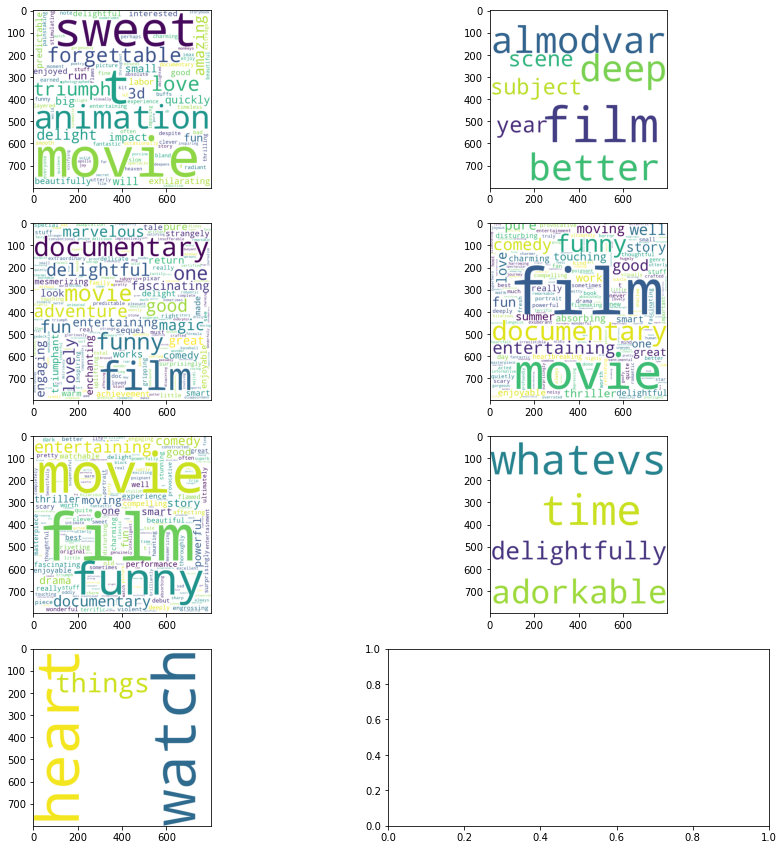

In [243]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
axs[0, 0].imshow(wordcloud)
axs[0, 1].imshow(wordcloud_NC_17)
axs[1, 0].imshow(wordcloud_pg)
axs[1, 1].imshow(wordcloud_pg_13)
axs[2, 0].imshow(wordcloud_r)
axs[2, 1].imshow(wordcloud_tv14)
axs[3, 0].imshow(wordcloud_tvma)

In [246]:
timeseries = merged.groupby('Year')['char_words'].sum()

In [247]:
my_dict = {}
for i in range(len(timeseries)):
    comment_words = ''
    comment_words += " ".join(timeseries.iloc[i])+" "
    my_dict[timeseries.index[i]] = comment_words

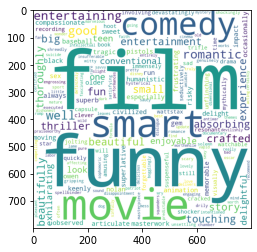

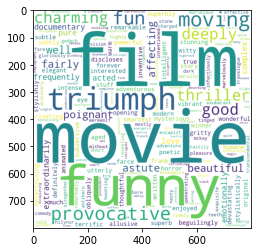

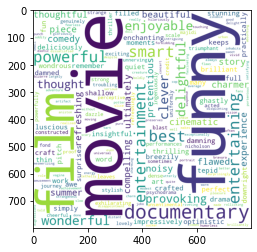

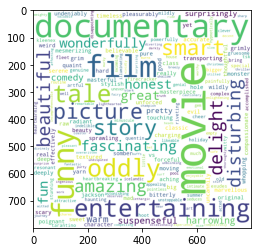

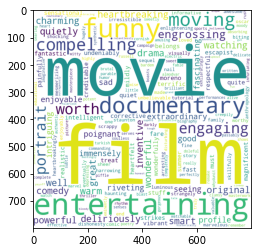

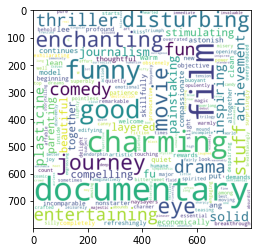

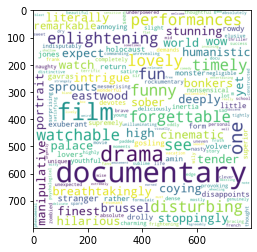

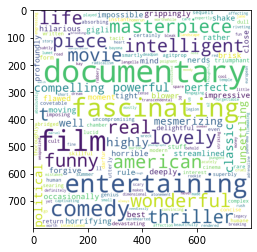

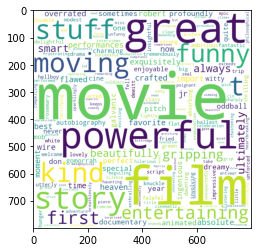

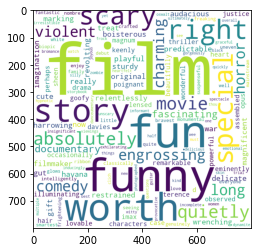

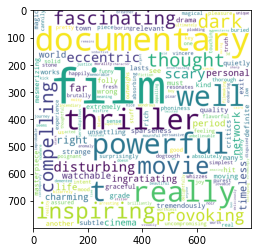

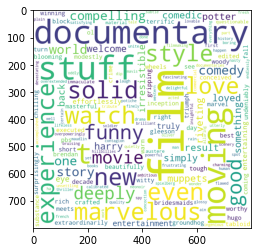

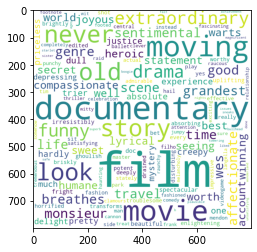

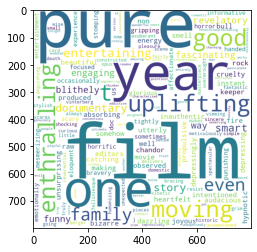

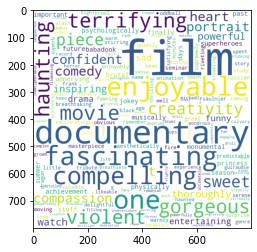

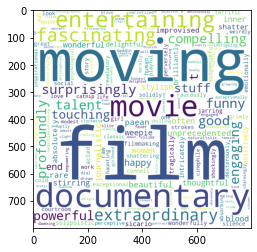

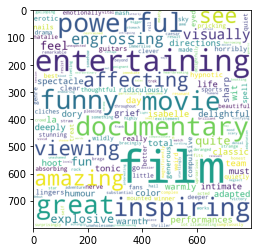

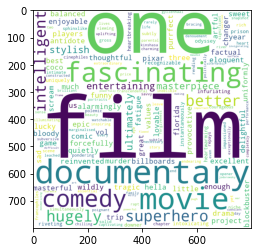

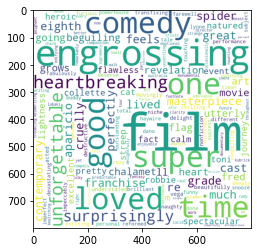

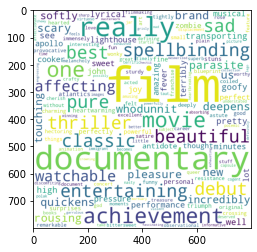

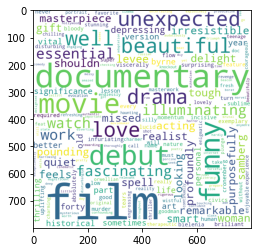

In [252]:
for i in my_dict:
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(my_dict[i])
    plt.imshow(wordcloud)
    plt.show()